# Malaria Cells Image Classification
![](https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2013/08/26/10/13/ds00475_im00175_mcdc7_malaria_transmitthu_jpg.jpg)

This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/

The dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells. An instance of how the patient-ID is encoded into the cell name is shown herewith: “P1” denotes the patient-ID for the cell labeled “C33P1thinF_IMG_20150619_114756a_cell_179.png”. We have also included the CSV files containing the Patient-ID to cell mappings for the parasitized and uninfected classes. 

# 1. Importing Packages and Collecting Data

In [1]:
'''Importing the Moduls'''
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow 
print('Tensorflow version',tensorflow.__version__)

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

import os
print(os.listdir("../input/cell-images-for-detecting-malaria/cell_images/cell_images"))

Tensorflow version 2.1.0
['Uninfected', 'Parasitized']


In [2]:
!pip install split-folders

In [3]:
'''Train and Test split on a dataset with directories'''
import split_folders
orig_path = '../input/cell-images-for-detecting-malaria/cell_images/cell_images'
output_path = '../output'
split_folders.ratio(orig_path, output=output_path, seed=1, ratio=(.8, .2))

Copying files: 27560 files [01:16, 360.04 files/s]


In [4]:
'''Preview the split'''
data_dir = '../output'
print(os.listdir(data_dir))

['train', 'val']


In [5]:
'''Creating train and test paths'''
train = data_dir+'/train/'
test = data_dir+'/val/'

In [6]:
'''Preview the train and test directories'''
print(os.listdir(train))
print('\n')
print(os.listdir(test))

['Uninfected', 'Parasitized']


['Uninfected', 'Parasitized']


# 2. Exploring the Image

In [7]:
'''Reading the Single Uninfected image'''
print('Uninfected image:',os.listdir(train+'Uninfected')[0])
print('Parasitizes image:',os.listdir(train+'Parasitized')[0])

Uninfected image: C230ThinF_IMG_20151112_150329_cell_162.png
Parasitizes image: C182P143NThinF_IMG_20151201_171950_cell_202.png


In [8]:
uninf_cell = train+'Uninfected/'+'C230ThinF_IMG_20151112_150329_cell_162.png'
para_cell = train+'Parasitized/'+'C182P143NThinF_IMG_20151201_171950_cell_202.png'

In [9]:
"""Let's read the image file"""
cv2.imread(uninf_cell)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

**imread automatically change the image into array list. This are the pixel value of the image.**

In [10]:
"""Let's see the shape of the image"""
cv2.imread(uninf_cell).shape

(118, 127, 3)

**So,this particular image have 118 X 127 X 3 dimension that mean it is a color image.**

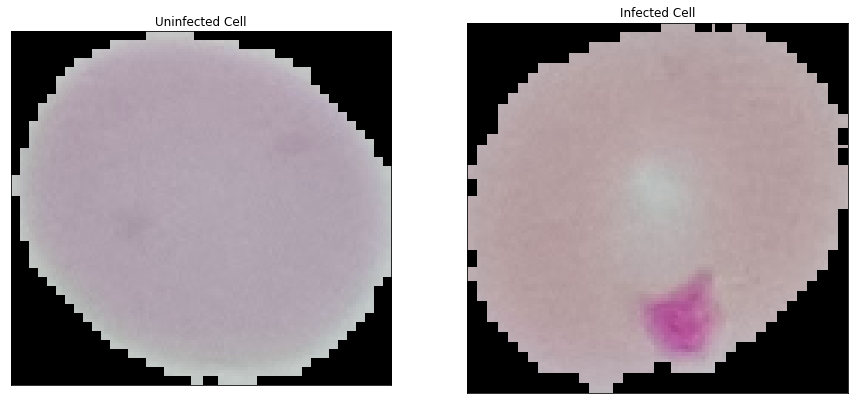

In [11]:
'''Preview the image'''
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cv2.imread(uninf_cell))
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cv2.imread(para_cell))
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

In [12]:
'''Number of image in the dataset'''
print('lenght of train parasitized', len(os.listdir(train+'Parasitized')))
print('lenght of train uninfected', len(os.listdir(train+'Uninfected')))
print('lenght of test parasitized', len(os.listdir(test+'Parasitized')))
print('lenght of test uninfected', len(os.listdir(test+'Uninfected')))

lenght of train parasitized 11024
lenght of train uninfected 11024
lenght of test parasitized 2756
lenght of test uninfected 2756


It seems that data is balanced. Something to note here is since these are real image files it's unlikely that they're all going to be the exact same shape. So, we have to reshape it.

In [13]:
'''Creating the loop to get the dimension of the image'''
dim1 = []
dim2 = []

for image_filename in os.listdir(train+'Uninfected'):
    try:
        img = cv2.imread(train+'Uninfected/'+image_filename)
        d1,d2,colors = img.shape
        dim1.append(d1)
        dim2.append(d2)
        
    except AttributeError:
        print('')

<Figure size 720x720 with 0 Axes>

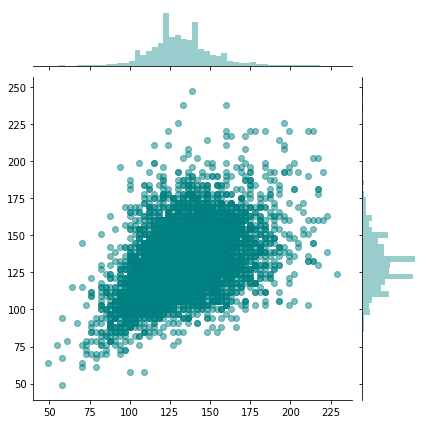

In [14]:
'''Plot the distribution of images dimensions'''
plt.figure(figsize=(10,10))
sns.jointplot(dim1,dim2, color='teal',alpha=0.5)
plt.show()

**we can see the various dimensions we have a really small image that's like 50 by 60 and a really large over 200 by 200 hundred. Let's take averge of the dimensions and reshape all the images in the same dimension becuase convolution neural network isn't going to be able to train on images of various sizes.**

In [15]:
'''Average of the dimensions'''
print(np.mean(dim1))
print(np.mean(dim2))

131.64247482536516
131.29220720312074


In [16]:
'''Final image shape that I will be feeding in my convolution network'''
image_shape = (130,130, 3)

# Then later on or actually preparing the data for the model we'll resize everything to these dimensions.

# 3. Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [17]:
'''Create image generator'''
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

train_image_gen = ImageDataGenerator(rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rescale=1./255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

test_image_gen = ImageDataGenerator(rescale=1./255)

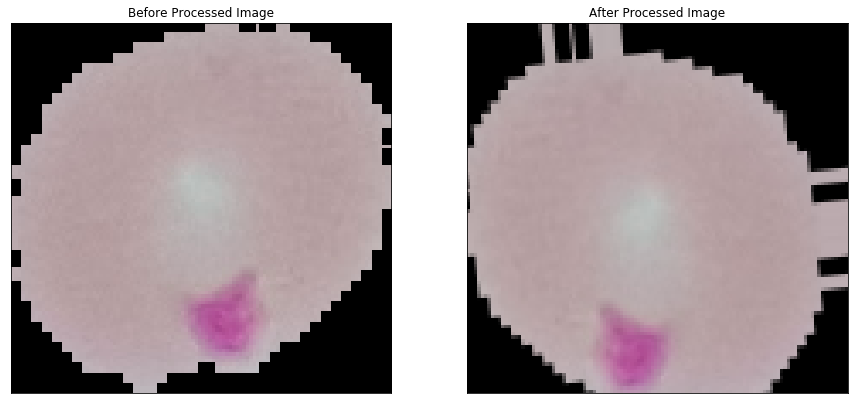

In [18]:
'''Preview the image'''
para_img = cv2.imread(para_cell)

plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(para_img)
plt.title('Before Processed Image')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(train_image_gen.random_transform(para_img))
plt.title('After Processed Image')
plt.xticks([]) , plt.yticks([])

plt.show()  

**So, we can see that randomize version of the image. we notice that we got some stretch. And that's because through this random transformation it looks like it got stretched out and it filled in those values with the nearest pixel value.**

**And then note it was also rotated makes a lot of sense to randomly rotate images here because their cells that can be in any sort of rotational axis that they want.**

# 3. Model CNN and Evalution

In [19]:
'''Set the CNN model'''
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
          
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

          
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        3

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=2)

**To implement the flow_from_directory. The input folder shoud have the following format:**
`input/
    class1/
        img1.jpg
        img2.jpg
        ...
    class2/
        imgWhatever.jpg
        ...
    ...`

In [22]:
'''Set up the generator to flow batches from directory'''
batch_size = 16

train_generator = train_image_gen.flow_from_directory(train,
                                                      target_size=image_shape[:2],
                                                      color_mode='rgb',
                                                      batch_size=batch_size,
                                                      class_mode='binary')

test_generator = test_image_gen.flow_from_directory(test,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False)

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [23]:
"""Let's see the target"""
train_generator.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [24]:
'''Training the model'''
history = model.fit_generator(train_generator, epochs=20,
                              validation_data = test_generator,
                              callbacks=[early_stop])

Train for 1378 steps, validate for 345 steps
Epoch 1/20
1378/1378 [==============================] - 463s 336ms/step - loss: 0.6020 - accuracy: 0.6500 - val_loss: 0.1842 - val_accuracy: 0.9336
Epoch 2/20
1378/1378 [==============================] - 461s 334ms/step - loss: 0.2122 - accuracy: 0.9315 - val_loss: 0.1557 - val_accuracy: 0.9512
Epoch 3/20
1378/1378 [==============================] - 461s 335ms/step - loss: 0.1925 - accuracy: 0.9407 - val_loss: 0.1426 - val_accuracy: 0.9550
Epoch 4/20
1378/1378 [==============================] - 456s 331ms/step - loss: 0.1829 - accuracy: 0.9430 - val_loss: 0.1492 - val_accuracy: 0.9530
Epoch 5/20
1378/1378 [==============================] - 462s 335ms/step - loss: 0.1766 - accuracy: 0.9461 - val_loss: 0.1325 - val_accuracy: 0.9583
Epoch 6/20
1378/1378 [==============================] - 463s 336ms/step - loss: 0.1706 - accuracy: 0.9469 - val_loss: 0.1363 - val_accuracy: 0.9566
Epoch 7/20
1378/1378 [==============================] - 462s 335ms/

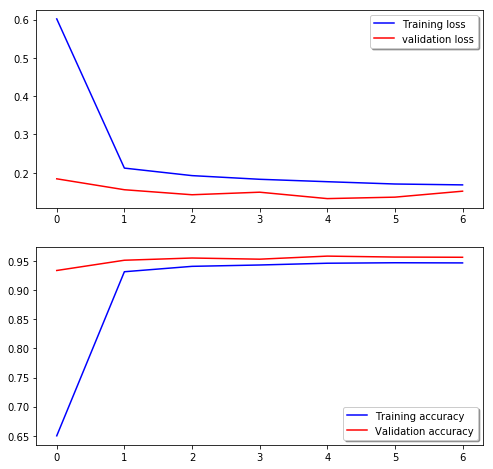

In [25]:
'''Training and validation curves'''
fig, ax = plt.subplots(2,1, figsize = (8,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Give me your feedback and if you find my kernel helpful please UPVOTE will be appreciated